In [1]:
import os
import warnings
import time
from copy import deepcopy

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d, interp2d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties, SourceProperties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse

In [2]:
from lcbg.utils import cutout, measure_fwhm, angular_to_pixel, natural_sort, plot_target, closest_value_index, get_interpolated_values
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D, model_to_image
from lcbg.segmentation import get_source_e, get_source_ellip, get_source_theta, plot_segment_residual, plot_segments, make_segments, get_source_position, deblend_segments, segm_mask, masked_segm_image
from lcbg.photometry import flux_to_abmag, order_cat, calculate_photometic_density, plot_apertures, radial_elliptical_aperture, radial_elliptical_annulus, plot_apertures
from lcbg.cosmology import cosmo_aperture_diameter
from lcbg.petrosian import calculate_petrosian, calculate_petrosian_r, calculate_r_half_light, calculate_r_total_flux, plot_petrosian

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Load Data

In [7]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

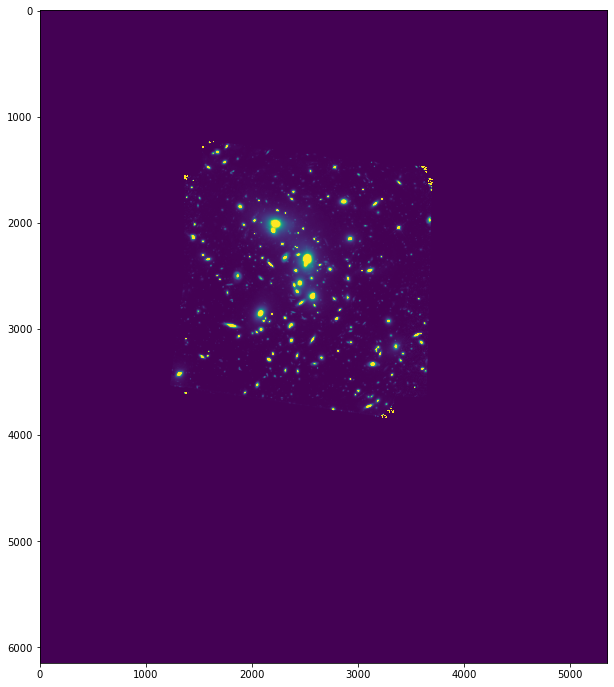

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

#  Estimate Data Noise

-0.00012860226 0.0038543560076504946 0.010278282687067986


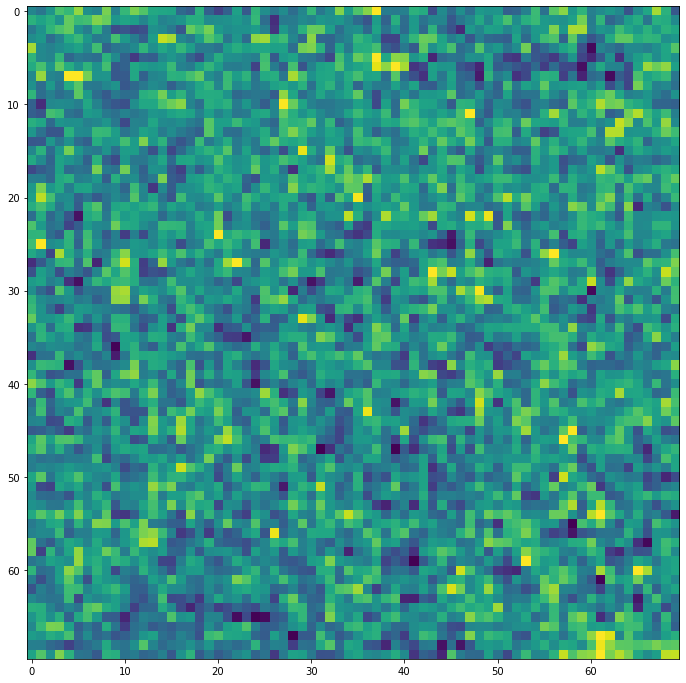

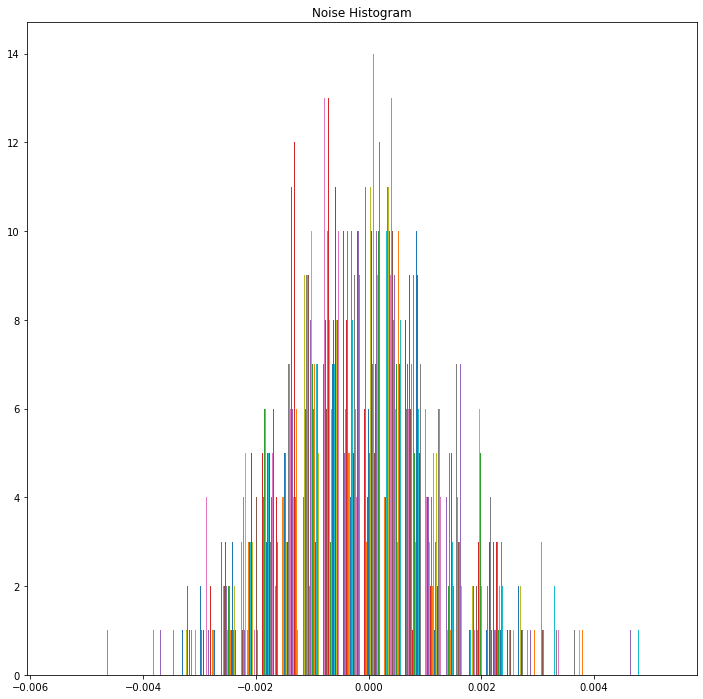

In [9]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2760, 3420), 70)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.show()

plt.hist(noise_cutout.data, bins=30)
plt.title('Noise Histogram')
plt.show()


# Make Cutout Image of Targets

0.01994735


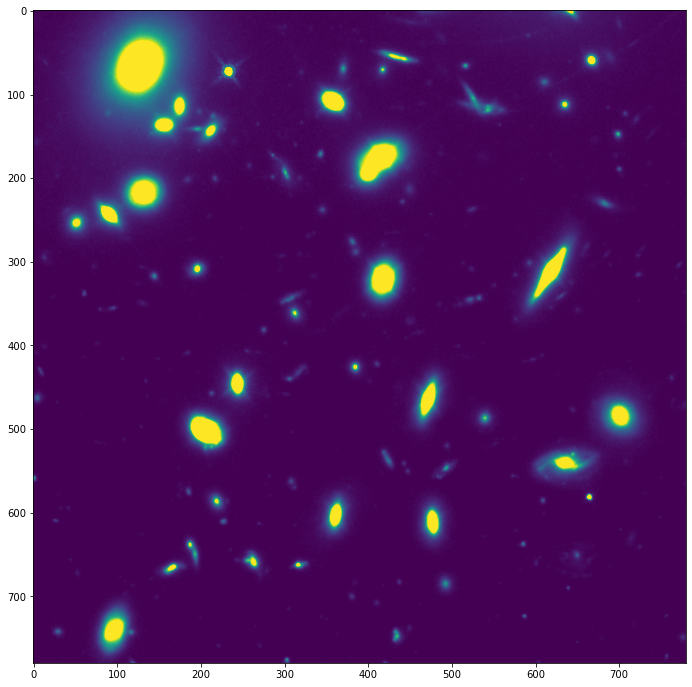

In [10]:
# Cutout Image
# -------------
# Select and crop image:
# Center of cluster:
#cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
#size = 500

# Cutom center:
cx, cy, size = 2864, 3563, 100 # Small faint group of galaxies
cx, cy, size = 2340, 3180, 780 # Larger group of galaxies
#cx, cy, size = 2390, 3000, 1000 # Large slice of the sky 
#cx, cy, size = 1738, 1434, 150 # Single Bright galaxy 

image = Cutout2D(data, (cx, cy), size, copy=True)

# MODEL IMAGE REPLACE
#model_1 = models.Sersic2D(amplitude=1, n=1, r_eff=10, theta=2., ellip=0.5)
#model_image = model_to_image(0,0,size,model_1)
#model_image = np.clip(model_image, 0, image.data.max())
#gaussian_2D_kernel = Gaussian2DKernel(3)
#model_image = convolve(model_image , gaussian_2D_kernel)
#image.data += #+ np.random.normal(noise_mean, noise_sigma, size=model_image.shape)

# Smooth the image
#gaussian_2D_kernel = Gaussian2DKernel(10)
#image.data = convolve(image.data, gaussian_2D_kernel)

# Clip data
image.data = np.clip(image.data, 0, image.data.max())

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
image.data  -= image_clipped_median

# Set min and max values for all plots
vmin = 0
vmax = image_mean*10

plt.imshow(image.data, vmin=vmin, vmax=vmax)
print(image_mean)

# Make Segmentation Map and Source Catalog

Num of Targets: 47


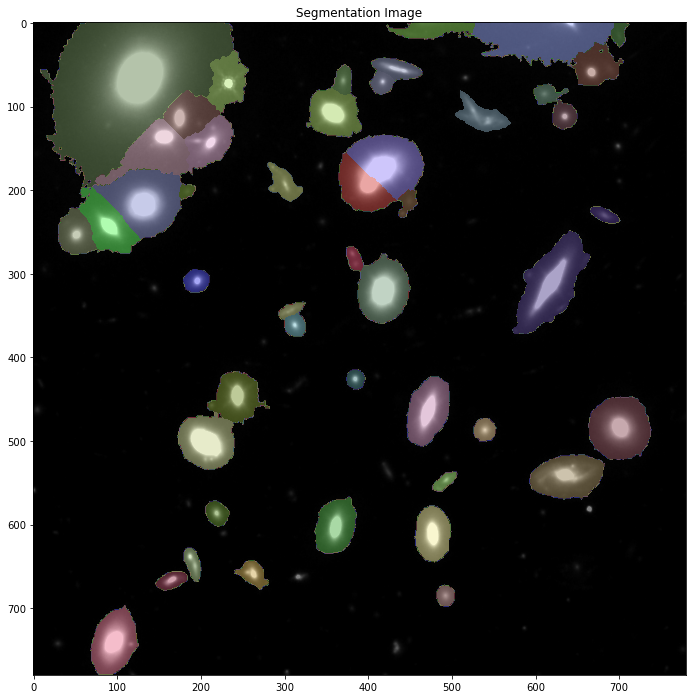

In [11]:
# Catalog
# -------

# Define detect threshold
nsigma = 3

# Define smoothing kernel

kernel_size = 5

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, kernel_size=kernel_size, fwhm=5, npixels=20**2)


# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, kernel_size=kernel_size, fwhm=5, npixels=10**2)

# Remove border sources
# segm_deblend.remove_border_labels(100)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Plot segments
plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()

### Inspect the segmented sources by unmasking the target one at a time

In [12]:
# Test out masked_segm_image
def slider(x):
    plt.imshow(masked_segm_image(cat[x], image, segm_deblend).data, vmin=vmin, vmax=vmax)
    plt.show()

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=46), Output()), _dom_classes=('widget-inter…

# Define Aperture Radii

In [14]:
# List of radii
# -------------

#n = 50
#max_pix = 200
#r_list = [x * int(max_pix/n) for x in range(1, n+1)]

r_list = list(range(1, 50, 5))
r_list += list(range(50, 201, 10))

#r_list = np.logspace(np.log10(0.06),np.log10(14), 10) * u.arcsec # approximate isophotal extent
#r_list = angular_to_pixel(r_list, wcs=image.wcs) # convert to pixels
#r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

r_list = np.array(r_list)
print("max=", r_list[-1])
print("len=", len(r_list))

max= 200
len= 26


# Photometry

### Define photometry functions

In [15]:
def photometry_step(position, r_list, image, e=1., theta=0., annulus_r=None, annulus_dr=5,
                    subtract_bg=True, return_areas=False, bg_density=None,
                    plot=False, vmin=0, vmax=None):

    # Estimate background
    annulus = None
    if subtract_bg and bg_density is None:
        annulus_r = annulus_r if annulus_r else max(r_list)
        annulus = radial_elliptical_annulus(position, annulus_r, annulus_dr, e=e, theta=theta)
        bg_density = annulus.do_photometry(image.data)[0][0] / annulus.area
        bg_density = np.round(bg_density, 6)

    aperture_photometry_row = []
    aperture_area_row = []

    if plot:
        plt.imshow(image.data, vmax=image.data.mean()*10 if vmax is None else vmax)
        
    for i, r in enumerate(r_list):

        aperture = radial_elliptical_aperture(position, r, e=e, theta=theta)
        aperture_area = np.round(aperture.area, 6)

        photometric_sum = aperture.do_photometry(image.data)[0][0]

        photometric_value = np.round(photometric_sum, 6)

        if np.isnan(photometric_value):
            raise Exception("Nan photometric_value")

        if subtract_bg:
            photometric_bkg =  np.round(aperture_area * bg_density, 6)
            photometric_value -= photometric_bkg
            
        if plot:
            aperture.plot(plt.gca(), color='w', alpha=0.5)

        aperture_photometry_row.append(photometric_value)
        aperture_area_row.append(aperture_area)

    if plot and annulus is not None:
        annulus.plot(plt.gca(), color='r', linestyle='--', alpha=0.5)

    if return_areas:
        return aperture_photometry_row, aperture_area_row
    else:
        return aperture_photometry_row

In [16]:
def object_photometry(obj, mean_sub=False, plot=False):
    if plot:
        print(obj.id)
        fig, ax = plt.subplots(1, 2, figsize=[24,12])
    
    position = get_source_position(obj)
    e = get_source_e(obj)
    theta = get_source_theta(obj)
    
    cutout_size = max(r_list)*3
    
    # Estimate mean in coutuout
    masked_nan_image = masked_segm_image(obj, image, segm_deblend, fill=np.nan)
    masked_nan_image = Cutout2D(masked_nan_image.data, position, cutout_size, mode='partial', fill_value=np.nan)
    mean, median, std = sigma_clipped_stats(masked_nan_image.data, sigma=1.0, mask=np.isnan(masked_nan_image.data) )
    
    # Make coutuout
    masked_image = masked_nan_image.data 
    if mean_sub:
        masked_image -= mean
    
    # Convert nan values to mean 
    idx = np.where(np.isnan(masked_image))
    masked_image[idx] = 0. #np.random.normal(0., std, len(idx[0]))
    
    position = np.array(masked_image.data.shape) / 2.

    if plot:
        plt.sca(ax[0])
    aperture_photometry_row , a_list= photometry_step(position, r_list, masked_image, e=e, theta=theta, return_areas=True, 
                                                      plot=plot, vmax=image_mean, subtract_bg=False)
    
    if plot:
        plt.sca(ax[1])
        plt.plot(r_list, aperture_photometry_row, c='black', linewidth=3)
        for r in r_list:
            plt.axvline(r, alpha=0.5, c='r')
        plt.show()
        
        r = max(r_list)
        fig, ax = plt.subplots(1, 1, figsize=[24,6])
        plt.plot(masked_image[:, int(position[0])], c='black', linewidth=3)
        plt.axhline(0, c='black')
        #plt.axhline(noise_sigma, c='b')
        plt.axvline(position[0], linestyle='--')
        plt.axvline(position[0]+r, alpha=0.5, c='r')
        plt.axvline(position[0]-r, alpha=0.5, c='r')
        plt.xlabel("Slice Along Y [pix]")
        plt.ylabel("Flux")

                        
        fig, ax = plt.subplots(1, 1, figsize=[24,6])

        plt.plot(masked_image[int(position[1]), :], c='black', linewidth=3)
        plt.axhline(0, c='black')
        #plt.axhline(noise_sigma, c='b')
        plt.axvline(position[0], linestyle='--')
        plt.axvline(position[0]+r, alpha=0.5, c='r')
        plt.axvline(position[0]-r, alpha=0.5, c='r')
        plt.xlabel("Slice Along X [pix]")
        plt.ylabel("Flux")
        
    return aperture_photometry_row , a_list

### Test photometry function on one target at time

In [17]:
# Test photometry function
def slider(x):
    x = order_cat(cat)[x]
    obj = cat[x]
    f, a = object_photometry(obj, plot=True)
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=46), Output()), _dom_classes=('widget-inter…

### Do photomerty on all objects in the source catalog and save to file

In [18]:
# Photomerty
# ----------
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal'
)
display(pb)

single_aperture_photometry_table = cat.to_table()

aperture_photometry_rows = []
aperture_area_rows = []
for idx, obj in enumerate(cat):
    pb.value = idx + 1
    pb.description = "{}/{}".format(pb.value, len(cat))
    
    aperture_photometry_row, aperture_area_row = object_photometry(obj)
    
    aperture_photometry_rows.append(np.array(aperture_photometry_row))
    aperture_area_rows.append(aperture_area_row)
    
single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.add_columns(np.transpose(aperture_area_rows), names=["aperture_area_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
plt.show()

IntProgress(value=0, description='Loading:', max=47)

# Load Photometry Results

In [19]:
result_cat = Table.read(output_path)
result_cat.sort(keys="source_sum", reverse=1)
result_cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_001,aperture_sum_180,aperture_sum_170,aperture_sum_160,aperture_sum_150,aperture_sum_140,aperture_sum_130,aperture_sum_120,aperture_sum_110,aperture_sum_100,aperture_sum_090,aperture_sum_080,aperture_sum_070,aperture_sum_060,aperture_sum_050,aperture_sum_046,aperture_sum_041,aperture_sum_036,aperture_sum_031,aperture_sum_026,aperture_sum_021,aperture_sum_016,aperture_sum_011,aperture_sum_006,aperture_sum_190,aperture_sum_200,aperture_area_001,aperture_area_180,aperture_area_170,aperture_area_160,aperture_area_150,aperture_area_140,aperture_area_130,aperture_area_120,aperture_area_110,aperture_area_100,aperture_area_090,aperture_area_080,aperture_area_070,aperture_area_060,aperture_area_050,aperture_area_046,aperture_area_041,aperture_area_036,aperture_area_031,aperture_area_026,aperture_area_021,aperture_area_016,aperture_area_011,aperture_area_006,aperture_area_190,aperture_area_200
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20,125.34380503501373,66.91527323832166,"3.5948349582795798,-30.39162587687476","3.5948319257876653,-30.39162805308397",2822.1072,None,None,None,None,9.0,239.0,0.0,197.0,0.0028472154,10.600912,40.0,28.0,127.0,66.0,26456.0,91.76713109212015,941.2701653663385,29.806673358489963,20.610792231616134,-43.66952283013567,0.7223932366360234,0.3085175261349494,1.446168251250804,667.3835151841702,-231.56655280741666,645.8590179303933,0.0017112810472162325,0.0012271267938887465,0.0017683127881668805,0.7291764198810469,21.534972,2869.427404,2862.441514,2854.59331,2844.857311,2832.981372,2818.988432,2800.391509,2775.711702,2740.00889,2689.19968,2616.61553,2502.395244,2354.060223,2180.276793,2100.467459,1989.542581,1862.080776,1712.446623,1534.189465,1320.009878,1067.696091,770.465168,404.396844,2876.769503,2884.299744,2.172356,70384.342823,62781.095913,55612.320256,48878.01585,42578.182696,36712.820794,31281.930144,26285.510746,21723.5626,17596.085706,13903.080064,10644.545674,7820.482536,5430.89065,4596.705846,3651.730873,2815.373713,2087.634366,1468.512832,958.009111,556.123203,262.855107,78.204825,78422.060985,86894.250399
39,417.6485967745294,173.12489571391978,"3.5891870241933637,-30.389856040059012","3.589183991340016,-30.389858216827665",742.4023,None,None,None,None,374.0,467.0,134.0,213.0,0.004084928,10.805913,424.0,135.0,416.0,174.0,4530.0,37.97293489332332,279.747258045114,10.424692832804952,8.63735546386778,0.4188571055837614,0.5599184565454582,0.17145228138642987,1.2069310886201283,108.67239988923562,0.24905994203668447,74.60573017830593,0.009202038898972318,-6.143922911336357e-05,0.013403898717101572,0.7775439608509426,25.359401,871.677524,858.560555,843.103557,831.568187,822.583717,812.324999,803.739535,795.254929,785.700181,779.417536,773.085658,761.771706,752.614642,742.957583,738.745286,731.038899,719.522408,702.049234,674.52798,629.914104,551.111666,448.564978,308.943634,886.627724,900.76125,2.602959,84335.885401,75225.52741,66635.761304,58566.5870

In [20]:
mag_col_names = natural_sort([i for i in result_cat.colnames if "aperture_sum_" in i])
area_col_names = natural_sort([i for i in result_cat.colnames if "aperture_area_" in i])

# Calculate Petrosian

In [21]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(image.data, vmin=vmin, vmax=vmax)
    ax[0,0].set_xlim(x-size, x+size)
    ax[0,0].set_ylim(y-size, y+size)
    ax[0,0].set_title("Target {}".format(row['id']))
    
    ax[0,1].imshow(masked_image.data, vmin=vmin, vmax=vmax)
    ax[0,1].set_xlim(x-size, x+size)
    ax[0,1].set_ylim(y-size, y+size)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [x, y]
    
    for r in r_list:
        aperture = radial_elliptical_aperture(position, r, e=obj_e, theta=obj_theta)
        aperture.plot(ax[0,0], color='r', alpha=0.5)
        aperture.plot(ax[0,1], color='r', alpha=0.5)


    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(r_list, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = calculate_photometic_density(r_list, flux_list, e=obj_e, theta=obj_theta)
    ax[1,1].plot(r_list, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Density")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    # Petrosian
    # ---------
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=46), Output()), _dom_classes=('widget-inter…

# Inspect r_half_light and r_total_flux

In [22]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    
    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if r_half_light is None:
        print("r_half_light could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="--", label='R Half Light')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=46), Output()), _dom_classes=('widget-inter…

# concentration_index

In [23]:
from lcbg.petrosian import fraction_flux_to_r
def calculate_concentration_index(r_list, area_list, flux_list, ratio1=0.2, ratio2=0.8, eta=0.2):
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=eta)

    if r_total_flux > max(r_list):
        return None

    r_list_new, flux_list_new = get_interpolated_values(r_list, flux_list)

    f = interp1d(r_list, flux_list, kind='cubic')
    total_flux = f(r_total_flux)
    
    r1 = fraction_flux_to_r(r_list, area_list, flux_list, fraction=ratio1, eta=eta)
    r2 = fraction_flux_to_r(r_list, area_list, flux_list, fraction=ratio2, eta=eta)

    if None in [r1, r2]:
        return None
    
    return r1, r2, 5 * np.log10(r2/r1)

In [24]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    result = calculate_concentration_index(r_list, area_list, flux_list, eta=petrosian_number, ratio1=0.2, ratio2=0.8)
    if result is None:
        return 
    r1, r2, c2080 = result
    print("r_20={:0.2f} r_80={:0.2f} C2080={:0.2f}".format(r1, r2, c2080))
    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if None in [r_half_light, r1, r2]:
        print("Could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="-", label='R Half Light')
        aperture = radial_elliptical_aperture(position, r1, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_20')
        aperture = radial_elliptical_aperture(position, r2, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_80')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));



interactive(children=(BoundedIntText(value=0, description='x', max=46), Output()), _dom_classes=('widget-inter…

# Fit Sersic Model and Compare Cumulative Photometries

In [25]:
def estimate_n(c2080pet):
    n_list = [0.5, 0.75, 1, 1.5, 2, 4, 6, 8]
    c_pet_list = [2.14, 2.49, 2.78, 3.26, 3.63, 4.50, 4.99, 5.31]
    f = interp1d(c_pet_list, n_list, kind='cubic')
    return f(c2080pet)

In [26]:
def print_model_params(model):
    for param, value in zip(model.param_names, model.parameters):
        print("{:0.4f}\t{}".format(value,param))

In [28]:
def fit_sersic(image, x, y, r_1, r_2=None, sersic_n=3.0, ellip=0, theta=0, xy_slack=0, plot=False):
    
    g = EllipseGeometry(x, y, 1., ellip, theta)
    g.find_center(image)
    ellipse = Ellipse(image, geometry=g)
    
    iso_1 = ellipse.fit_isophote(r_1)
    
    model_1 = models.Sersic2D(
        amplitude=iso_1.intens,
        n=sersic_n,
        r_eff=r_1,    
        ellip=iso_1.eps,
        theta=iso_1.pa,
        x_0=x,
        y_0=y,
        fixed={'ellip':True,'theta':True,},
        bounds={
            'amplitude': (0, image.max()),
            'r_eff': (0, None),
            'n': (0, 7),
            'ellip': (0, 1),
            'theta': (0, 2 * np.pi),
            'x_0': (iso_1.x0 - xy_slack, iso_1.x0 + xy_slack),
            'y_0': (iso_1.y0 - xy_slack, iso_1.y0 + xy_slack),
        })

    model = model_1
    
    if r_2:
        iso_2 = ellipse.fit_isophote(r_2)
        model_2 = models.Sersic2D(
            amplitude=0,
            n=1,
            r_eff=r_2,
            ellip=iso_2.eps,
            theta=iso_2.pa,
            x_0=iso_2.x0,
            y_0=iso_2.y0,
            bounds={
                'amplitude': (0, image.max()),
                'r_eff': (0, None),
                'n': (0, 5),
                'ellip': (0, 1),
                'theta': (0, 2 * np.pi),
                #'x_0': (iso_2.x0-xy_slack, iso_2.x0+xy_slack),
                #'y_0': (iso_2.y0-xy_slack, iso_2.y0+xy_slack),
            })
        
        
        model_3 = models.Gaussian2D(
                amplitude=0,
                x_mean=model_1.x_0,
                y_mean=model_1.y_0,
                #fixed={'x_mean': True, 'y_mean': True, },
                bounds={
                    'amplitude': (0, None),
                }
        )
        
        
        #mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        #const = models.Const2D(amplitude=mean, bounds={'amplitude':(-3*std, 3*std)})
    
        model =  model_1 + model_2 #+ model_3
        
    
    model, fit = fit_model(image, model, maxiter=10000, epsilon=0)
    model, fit = fit_model(image, model, maxiter=10000, epsilon=0)
    model, fit = fit_model(image, model, maxiter=10000, epsilon=0)
    
    model.x_0 = model_1.x_0
    model.y_0 = model_1.y_0
    if plot:
        model_image = 0#model_to_image(model.x_0.value, model.y_0.value, image.shape[0], model)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(abs(image-model_image), vmin=vmin, vmax=vmax/2)
        ax.set_title("791 wide filter")

        ax.plot(x, y, '+', c='r', label='Target')

        # go to the outermost successfully fitted ellipse at sma=235
        isos = []
        x, y, = iso_1.sampled_coordinates()
        ax.plot(x, y, color='r')

        if r_2:
            x, y, = iso_2.sampled_coordinates()
            ax.plot(x, y, color='r')
    #print_model_params(model)
    return model, fit

In [31]:
def plot_fit(image, model, vmin=None, vmax=None):
    if isinstance(model, models.Sersic2D):
        x_0, y_0 = model.x_0, model.y_0  # Center
    elif isinstance(model, models.Gaussian2D):
        x_0, y_0 = [i.value for i in [model.x_mean, model.y_mean]]
    else:
        x_0, y_0 = model.x_0, model.y_0  # Center

    if isinstance(x_0, Parameter):
        x_0, y_0 = [int(i.value) for i in [x_0, y_0]]

    fig = plt.figure(figsize=(12, 12))

    # Make x and y grid to plot to
    y_arange, x_arange = np.mgrid[:image.shape[0], :image.shape[1]]

    # Plot input image with FWHM and center
    # -------------------------------------
    ax0 = fig.add_subplot(221)

    ax0.imshow(image, vmin=vmin, vmax=vmax)
    ax0.axvline(x_0, label="Center")
    ax0.axhline(y_0)

    ax0.set_title("Image")
    ax0.set_xlabel("X Pixel")
    ax0.set_ylabel("Y Pixel")

    ax0.legend()

    # Plot residuals
    # ---------------

    residuals = image - model(x_arange, y_arange)
    # residuals[np.where(residuals < 0)] = 0.
    ax1 = fig.add_subplot(222)
    ax1.imshow(residuals, vmin=vmin, vmax=vmax)

    ax1.set_title("Residual (Image - Fit)")
    ax1.set_xlabel("X Pixel")
    ax1.set_ylabel("Y Pixel")

    # Prepare fine grid
    # -----------------

    # We need a fine grid to fill in inter-pixel values
    # Oversample by a factor of 10

    y_arange_fine, x_arange_fine = np.mgrid[:image.shape[0] * 10, :image.shape[1] * 10] / 10

    fine_image = model(x_arange_fine, y_arange_fine)
    x_slice_fine = fine_image[fine_image.shape[0] // 2, :]
    y_slice_fine = fine_image[:, fine_image.shape[1] // 2]

    # Plot X fit
    # ----------

    ax2 = fig.add_subplot(223)

    ax2.plot(x_arange_fine[1, :], x_slice_fine, c='r')
    ax2.scatter(x_arange[1, :], image[int(np.round(y_0)), :], c='black')

    ax2.set_title("X Cross Section")
    ax2.set_xlabel("X Pixel")
    ax2.set_ylabel("Flux")

    # Plot Y fit
    # ----------

    ax3 = fig.add_subplot(224)

    ax3.plot(y_arange_fine[:, 1], y_slice_fine, c='r')
    ax3.scatter(y_arange[:, 1], image[:, int(np.round(x_0))], c='black')

    ax3.set_title("Y Cross Section")
    ax3.set_xlabel("Y Pixel")
    ax3.set_ylabel("Flux")

    return fig, [ax0, ax1, ax2, ax3]

In [33]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))

    obj_e = row['elongation']
    obj_ellip = row['ellipticity']
    obj_theta = np.deg2rad(row['orientation']) 

    masked_image = masked_segm_image(row['id'], image, segm_deblend, fill=0)

    size = max(r_list)
    x, y = get_source_position(row)

    # Plot Target
    # -----------
    #plt.figure(figsize=[2, 2])
    #plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    #plt.title("Target {}".format(row['id']))
    #plt.show()

    # Calculate r_half_light
    # -------------------
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=0.2)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=0.2)
    if r_half_light is None:
        print('Could not calculate r_half_light')
        return 

    # Make Cutout to fit
    # ------------------
    cutout_size = int(r_total_flux*2)
    if cutout_size % 2 != 0:
        cutout_size += 1

    # Estimate mean in coutuout
    target_zoom_nan_image = masked_segm_image(row['id'], image, segm_deblend, fill=np.nan, mask_background=False)
    target_zoom_nan_image = Cutout2D(target_zoom_nan_image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
    mean, median, std = sigma_clipped_stats(target_zoom_nan_image.data, sigma=1.0, 
                                            mask=np.isnan(target_zoom_nan_image.data) 
                                           )

    # Make coutuout
    target_zoom = target_zoom_nan_image.data #- median 

    # Convert nan values to mean 
    idx = np.where(np.isnan(target_zoom))
    target_zoom[idx] = np.nan#np.random.normal(0., std, len(idx[0]))
    target_x, target_y = np.array(target_zoom.data.shape) / 2.

    # Make models to fit
    # ------------------
    result = calculate_concentration_index(r_list, area_list, flux_list, eta=0.2, ratio1=0.2, ratio2=0.8)
    r20, r80, c2080 = result

    print('n_estimate=',estimate_n(c2080))
    rf = None #fraction_flux_to_r(r_list, area_list, flux_list, eta=0.2, fraction=0.8)
    model, fit = fit_sersic(target_zoom, target_x, target_y, r_half_light, r_2=rf, plot=True, 
                            sersic_n=estimate_n(c2080), ellip=obj_ellip, theta=obj_theta, xy_slack=1)
    #print_model_params(model)


    # Compute model photometry
    # ------------------------
    target_zoom[idx] = 0
    model_image = model_to_image(model.x_0.value, model.y_0.value, max(r_list)*2, model)
    model_fluxs, model_area_list = photometry_step(np.array(model_image.shape)/2, r_list, model_image,
                                                   e=obj_e, theta=obj_theta,
                                                   plot=False, subtract_bg=False, vmax=vmax/2, 
                                                   return_areas=True)

    # Compute model petrosian_r
    # -------------------------
    r_petrosian_model = calculate_petrosian_r(r_list, model_area_list, model_fluxs)
    if not r_petrosian_model:
        r_petrosian_model = 0.0
    print("r_pe/trosian_data = {:0.2f}\tr_petrosian_model = {:0.2f}".format(
        calculate_petrosian_r(r_list, area_list, flux_list),
        r_petrosian_model
        )
    )
    
    # Plots 
    # -----

    plt.show()

    plt.plot(r_list, flux_list, label="Data", marker='o')
    plt.plot(r_list, model_fluxs, label="Model")

    #plt.legend()
    plt.show()

    # Plot fit
    fig, ax = plot_fit(target_zoom, model, vmin=image_clipped_std * - 5, vmax=image_clipped_std*5)

    plt.show()

    model_image = model_to_image(model.x_0.value, model.y_0.value, cutout_size, model)
    diff = target_zoom - model_image
    plt.plot(diff[:,int(target_x)], label='Difference')
    plt.plot(model_image[:,int(target_x)], label="model_image", linewidth=2.0)
    plt.plot(target_zoom[:,int(target_x)], label="Data", c='g')
    plt.plot(target_zoom[:,int(target_x)], label="Data", marker='o', alpha=0.2, c='g')
    plt.legend()
    """
    print(list(zip(model.param_names, model.param_sets)))
    print(np.unique(model_image))
    plt.imshow(target_zoom, vmin=vmin, vmax=vmax/100)
    """
wd = widgets.interact(slider, x=widgets.BoundedIntText(min=2, max=len(result_cat)-1))

interactive(children=(BoundedIntText(value=2, description='x', max=46, min=2), Output()), _dom_classes=('widge…